## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

### Step 1: Camera calibration and Distortion Correction

In [2]:
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

def chessboard_corners(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(image, (9, 6), corners, ret)
    return ret, image

#calibrate the camera using 2D points and 3D points
def camera_calibration(img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

# Remove distortion from images
def undistort_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [3]:
def show_images_2(image1, label1, image2, label2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    ax1.set_title(label1, fontsize=20)
    ax2.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    ax2.set_title(label2, fontsize=20)

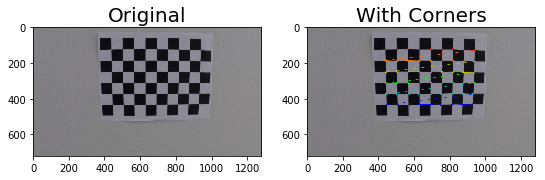

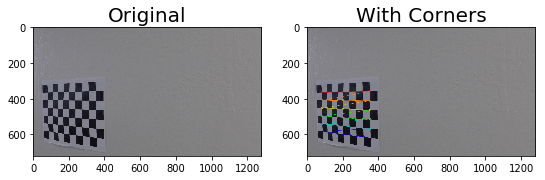

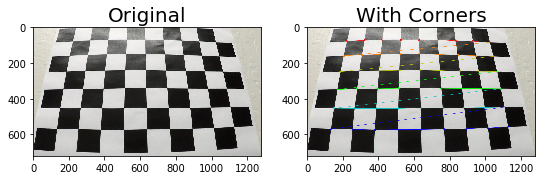

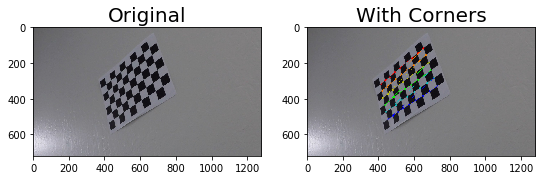

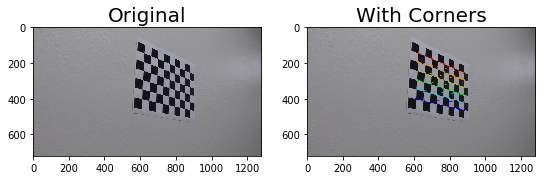

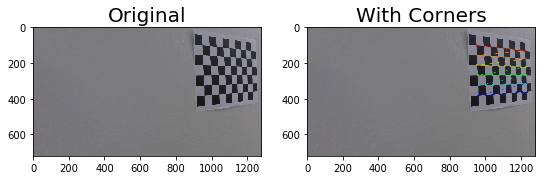

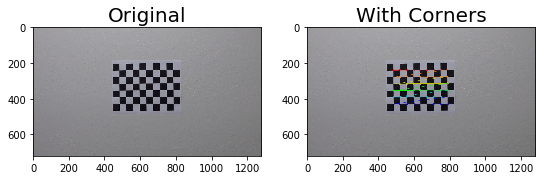

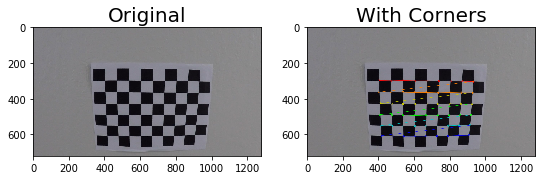

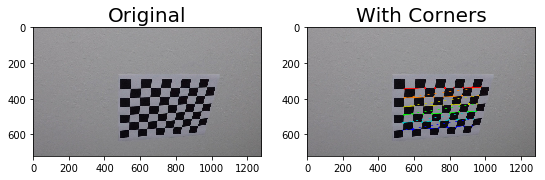

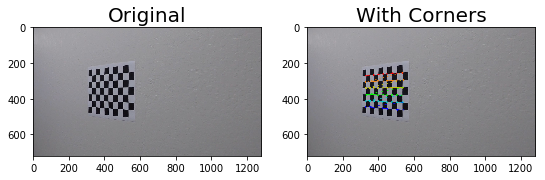

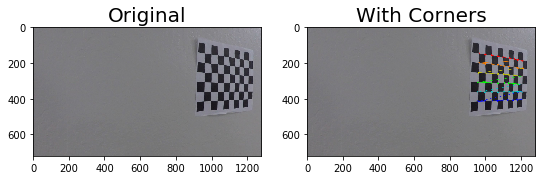

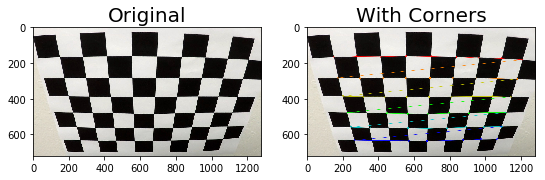

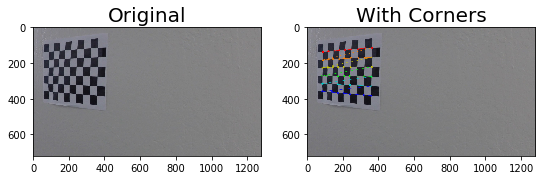

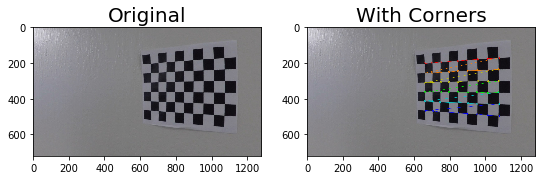

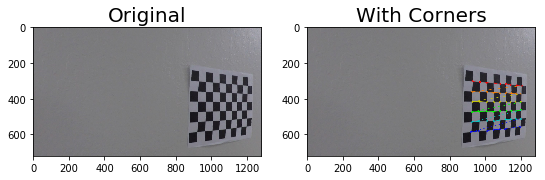

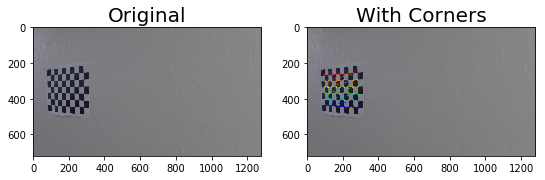

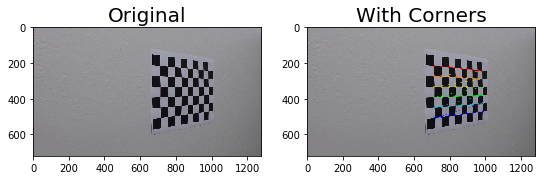

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')
for fimage in images:
    image = cv2.imread(fimage)
    ret, corners = chessboard_corners(image)
    if ret == True:
        show_images_2(image, 'Original', corners, 'With Corners')
    

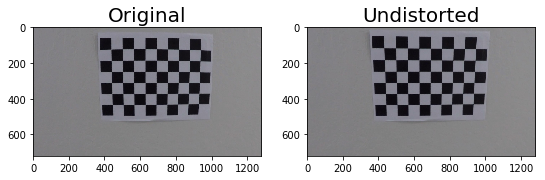

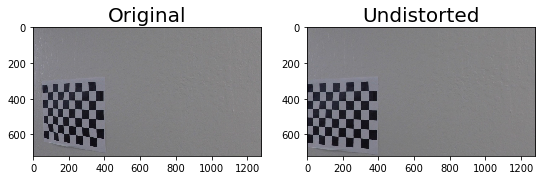

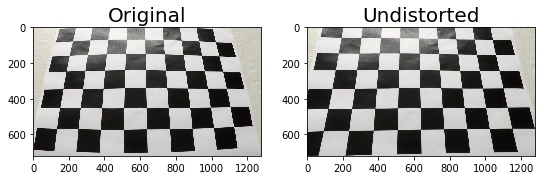

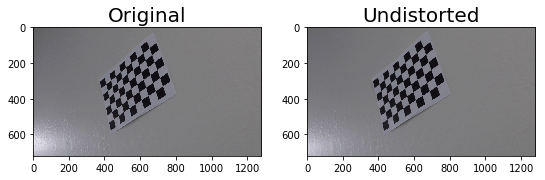

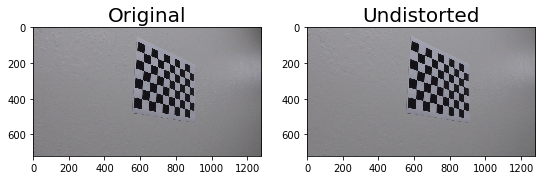

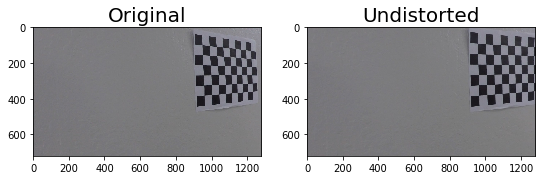

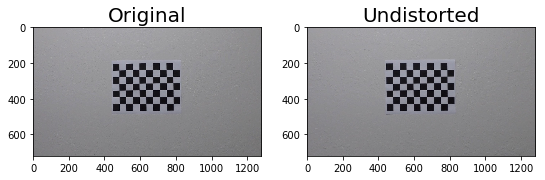

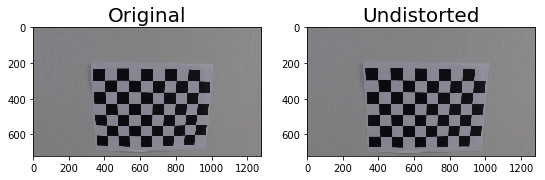

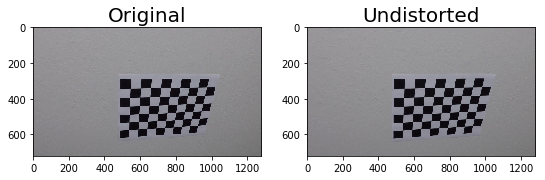

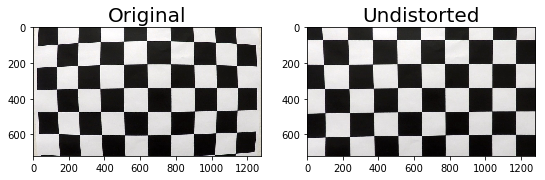

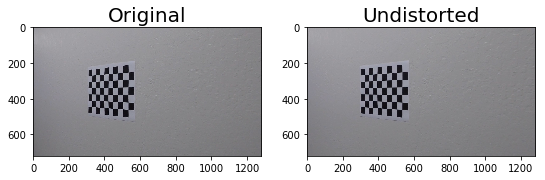

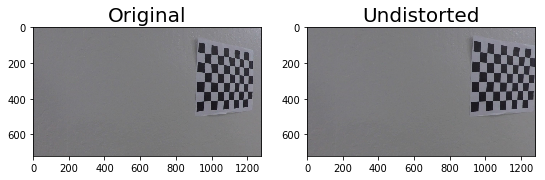

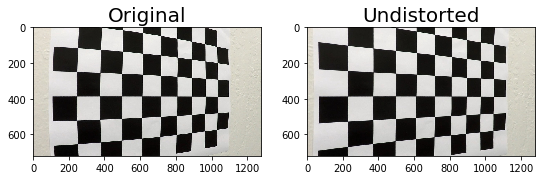

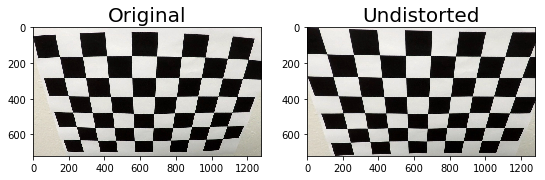

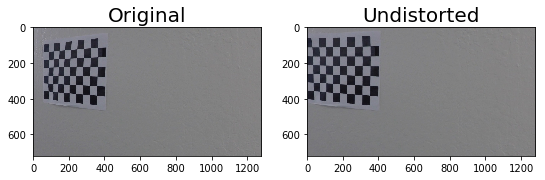

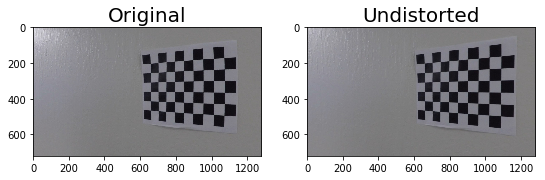

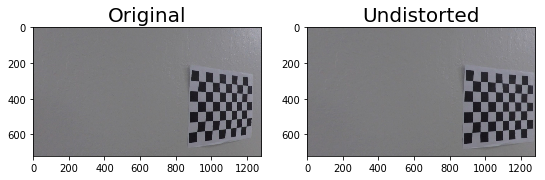

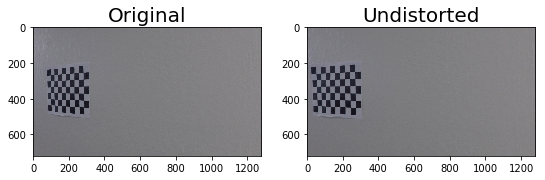

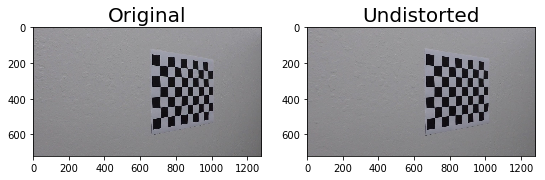

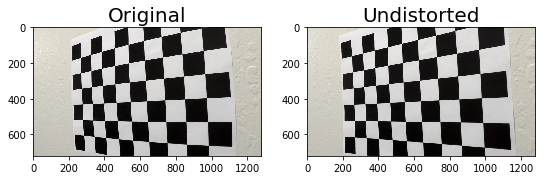

In [5]:
image = cv2.imread('camera_cal/calibration2.jpg')
mtx, dist = camera_calibration(image)
    
images = glob.glob('camera_cal/calibration*.jpg')
for fimage in images:
    image = cv2.imread(fimage)
    undistorted = undistort_image(image, mtx, dist)
    show_images_2(image, 'Original', undistorted, 'Undistorted')

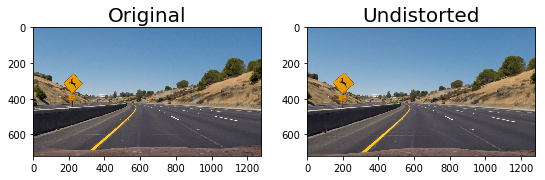

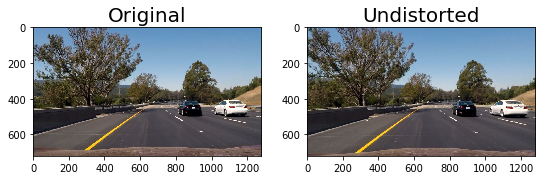

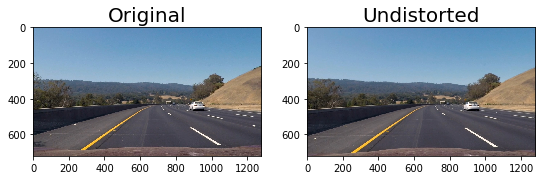

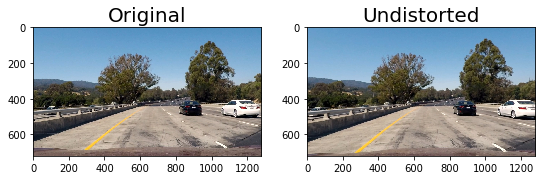

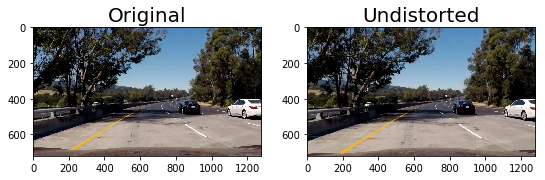

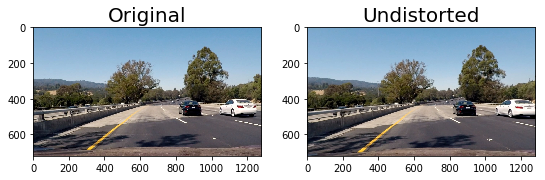

In [6]:
images = glob.glob('test_images/test*.jpg')

for fimage in images:
    image = cv2.imread(fimage)
    undistorted = undistort_image(image, mtx, dist)
    show_images_2(image, 'Original', undistorted, 'Undistorted')

### Step 2: Perspective Transform

In [7]:
# Perform perspective transform
def birds_eye_transform(img):
    img_size = (img.shape[1], img.shape[0])
    offset = 0
    src = np.float32([[490, 480],[810, 480],
                      [1250, 720],[40, 720]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                     [img_size[0]-offset, img_size[1]-offset], 
                     [offset, img_size[1]-offset]])
#     dst = np.float32([[0, 0], [1280, 0], 
#                      [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

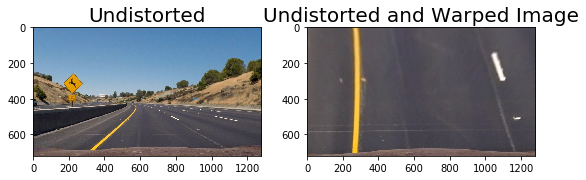

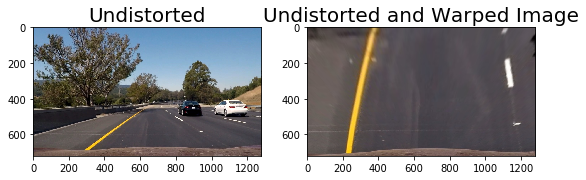

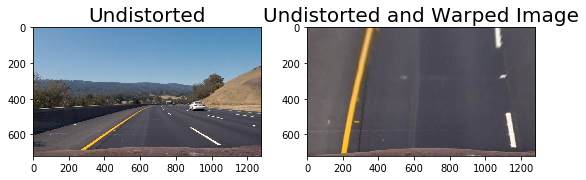

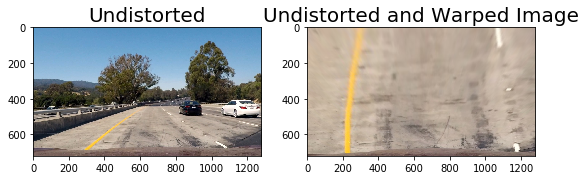

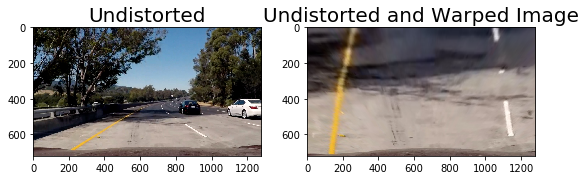

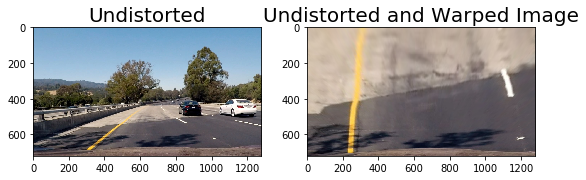

In [8]:
for fimage in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(fimage)
    undistorted = undistort_image(image, mtx, dist)
    warped, M, Minv = birds_eye_transform(undistorted)
    show_images_2(image, 'Undistorted', warped, 'Undistorted and Warped Image')

### Step 3: Binary Thresholds from Wrapped image

In [9]:
def hls_S_channel_thresholded(img, thresh=(170, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2]
#     hls_s = np.uint8(255*hls_s/np.max(hls_s))
    hls_s = hls_s*(255/np.max(hls_s))
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls_s)
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [10]:
def hls_L_channel_thresholded(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
#     hls_l = np.uint8(255*hls_l/np.max(hls_l))
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [11]:
def hls_H_channel_thresholded(img, thresh=(15, 100)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_h = hls[:,:,0]
#     hls_h = np.uint8(255*hls_h/np.max(hls_h))
    hls_h = hls_h*(255/np.max(hls_h))
    # 2) Apply a threshold to the H channel
    binary_output = np.zeros_like(hls_h)
    binary_output[(hls_h > thresh[0]) & (hls_h <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [12]:
def lab_B_channel_thresholded(img, thresh=(155, 255)):
    # 1) Convert to LAB color space
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
#     b_channel = hls_h = np.uint8(255*b_channel/np.max(b_channel))
    # 2) Apply a threshold to the L channel
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return b_binary

In [13]:
def sobel_x(img, thresh=(20,100)):
    b_binary = lab_B_channel_thresholded(img)

    # Sobel x
    sobelx = cv2.Sobel(b_binary, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

In [14]:
def show_threashold_image(image):
    
    l_binary = hls_L_channel_thresholded(image)
    b_binary = lab_B_channel_thresholded(image)
    s_binary = hls_S_channel_thresholded(image)
    sobel_binary = sobel_x(image)
    
    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary_b_l = np.zeros_like(l_binary)
    combined_binary_b_l[(b_binary == 1) | (l_binary == 1)] = 1
    
    combined_binary_s_b = np.zeros_like(s_binary)
    combined_binary_s_b[(b_binary == 1) | (s_binary == 1)] = 1
    
    combined_binary_s_b_l = np.zeros_like(l_binary)
    combined_binary_s_b_l[(b_binary == 1) | (l_binary == 1) | (s_binary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey='col', sharex='row', figsize=(20,4))
    f1, (ax5,ax6, ax7) = plt.subplots(1, 3, sharey='col', sharex='row', figsize=(25,4))
#         f.tight_layout()

    ax1.set_title('Warped Image', fontsize=16)
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('uint8'))

    ax2.set_title('B binary threshold', fontsize=16)
    ax2.imshow(b_binary, cmap='gray')

    ax3.set_title('S binary threshold', fontsize=16)
    ax3.imshow(s_binary, cmap='gray')

    ax4.set_title('L binary threshold', fontsize=16)
    ax4.imshow(l_binary, cmap='gray')

    ax5.set_title('Combinated S + L + B', fontsize=16)
    ax5.imshow(combined_binary_s_b_l, cmap='gray')

    ax6.set_title('Combined S + B', fontsize=16)
    ax6.imshow(combined_binary_s_b, cmap='gray')

    ax7.set_title('Combined B + L', fontsize=16)
    ax7.imshow(combined_binary_b_l, cmap='gray')

In [15]:
def threashold_image(image):
    
    l_binary = hls_L_channel_thresholded(image)
    b_binary = lab_B_channel_thresholded(image)
    
    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary_b_l = np.zeros_like(l_binary)
    combined_binary_b_l[(b_binary == 1) | (l_binary == 1)] = 1
    
    return combined_binary_b_l

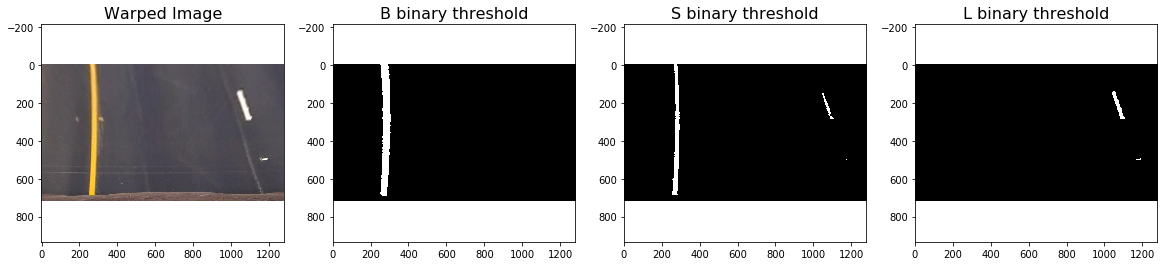

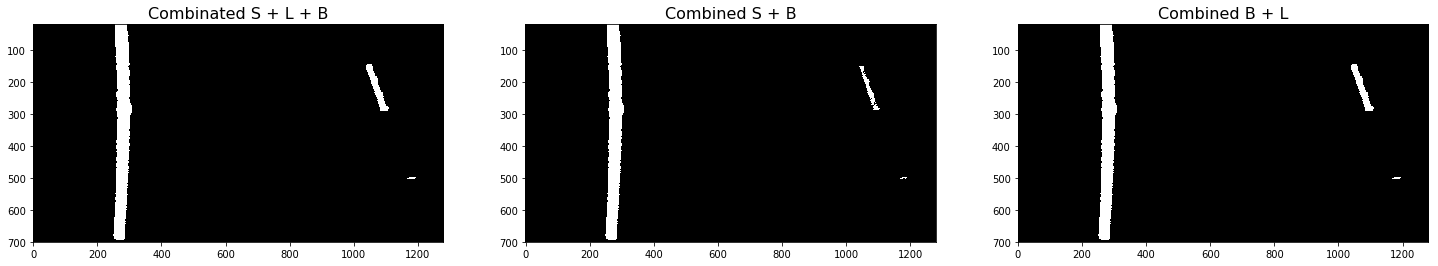

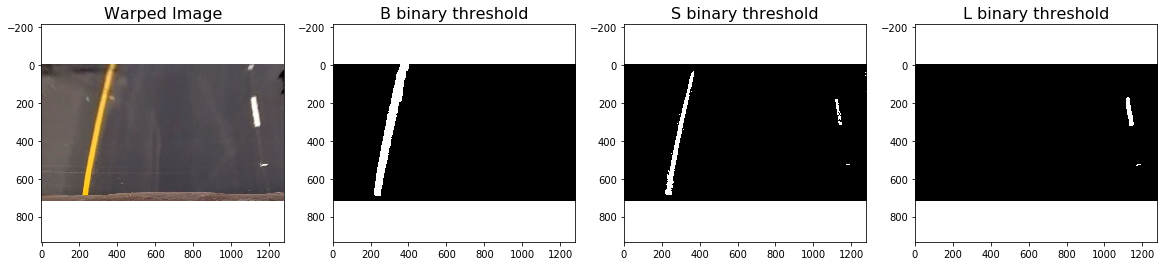

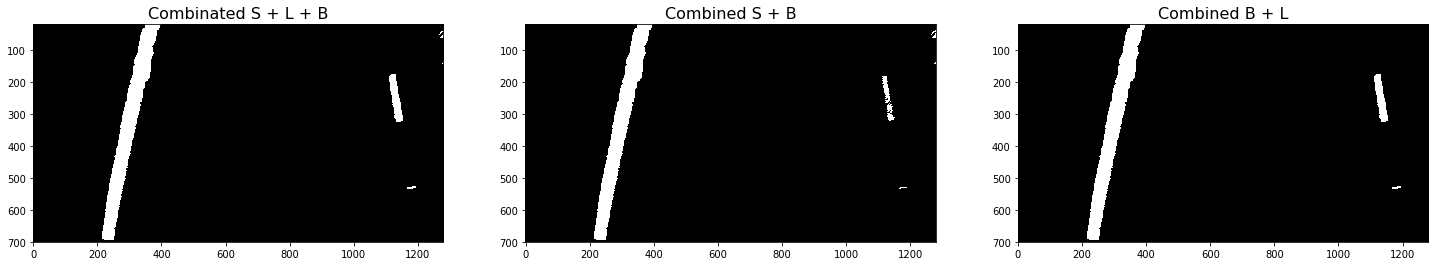

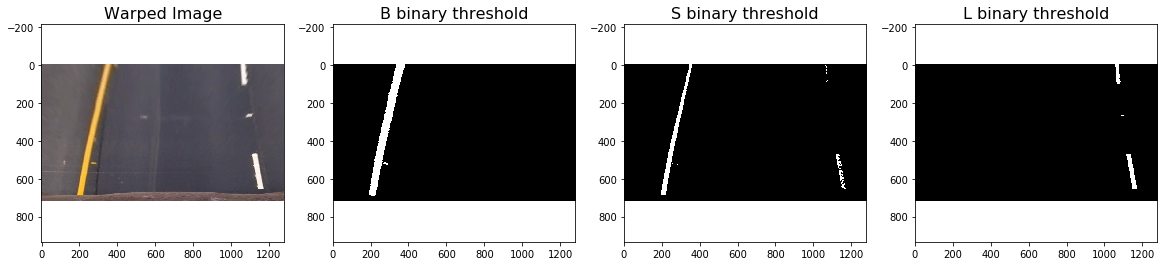

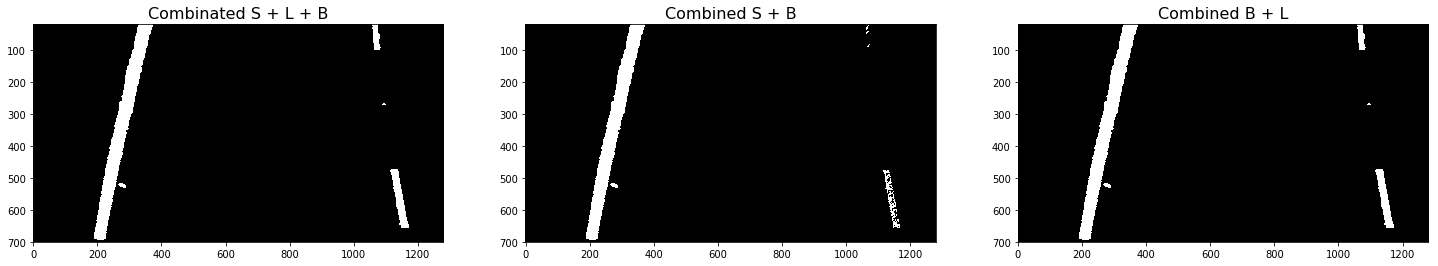

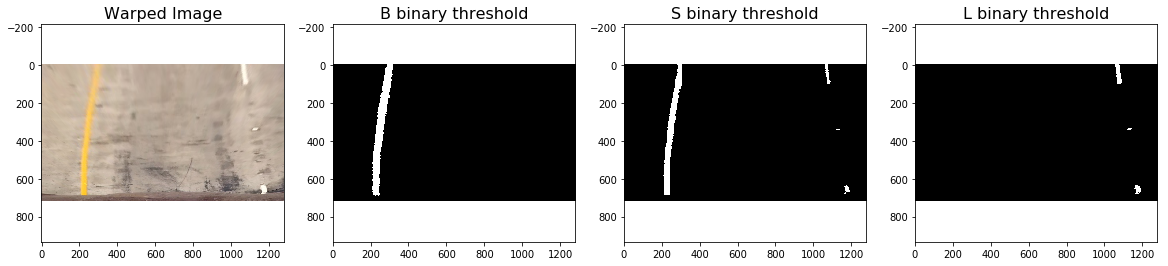

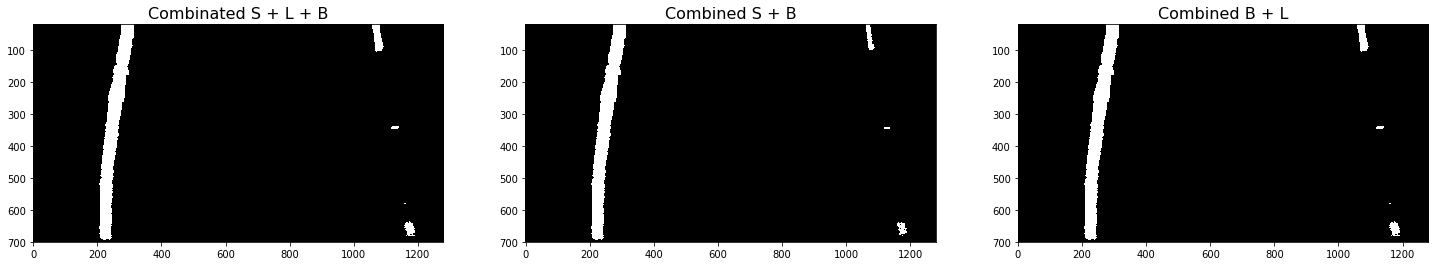

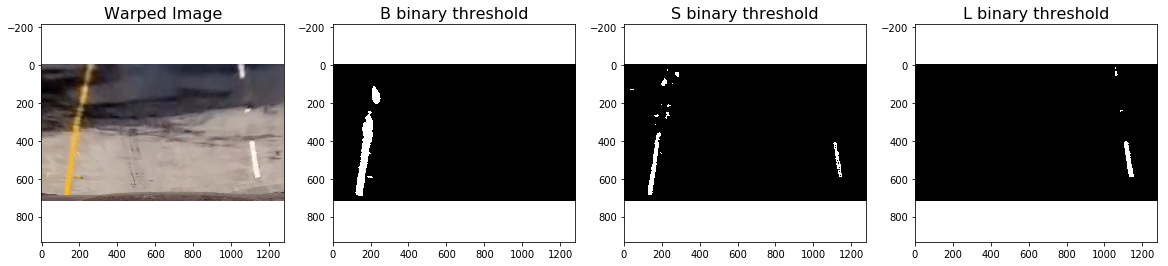

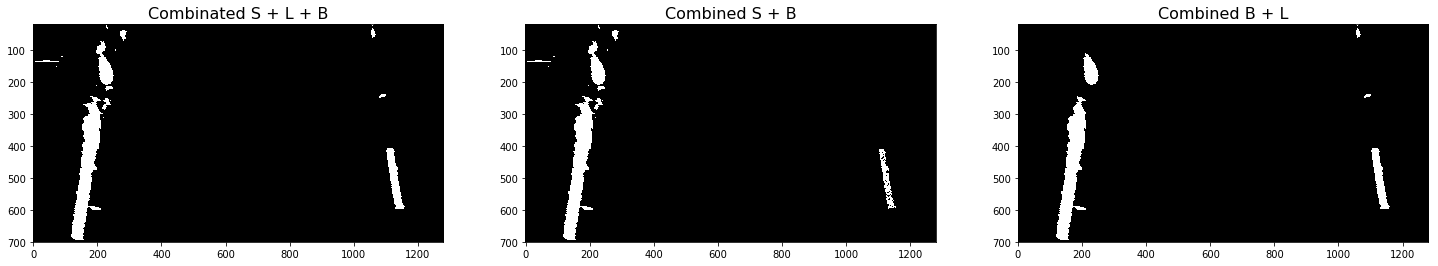

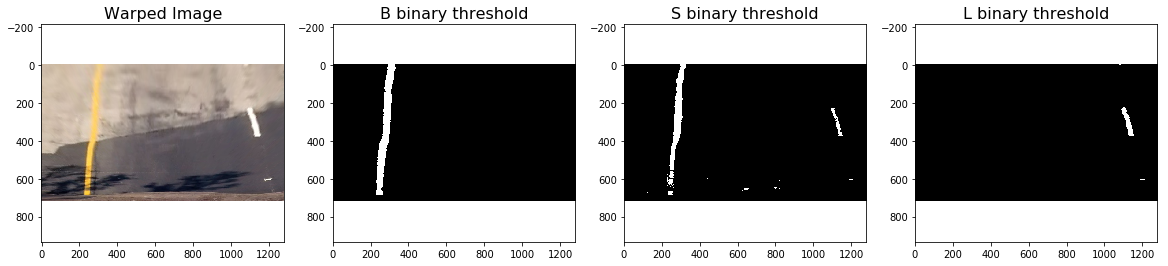

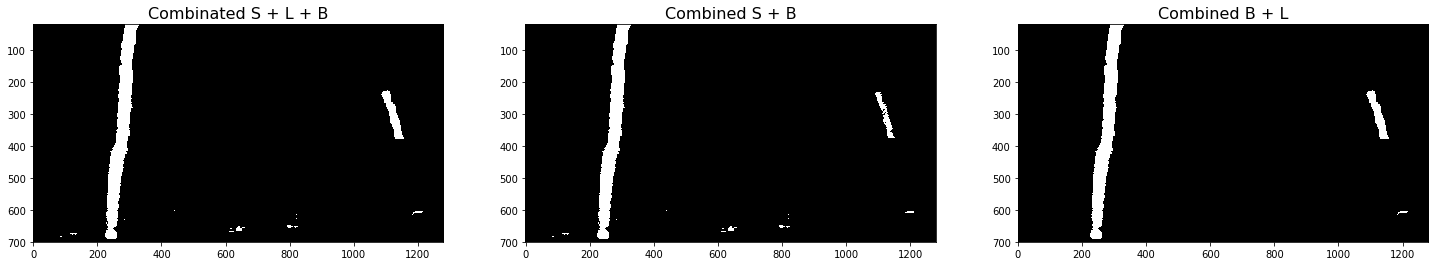

In [16]:
for fimage in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(fimage)
    wrapped, M, _ = birds_eye_transform(image)
    show_threashold_image(wrapped)

### Fit Lane

In [17]:
def fill_lane(image):
            
    combined_binary = image;
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(combined_binary[image.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(combined_binary.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Rectangle data for visualization
    rectangles = []

    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined_binary.shape[0] - (window+1)*window_height
        win_y_high = combined_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    calculated_data = (left_fit, right_fit, left_lane_inds, right_lane_inds)
    visualization_data = (rectangles, histogram)
    
    return calculated_data, visualization_data

In [43]:
def calculate_curv_rad_and_center(result, combined_binary, calculated_data):
    
    left_fit = calculated_data[0]
    right_fit = calculated_data[1]
    left_lane_inds = calculated_data[2]
    right_lane_inds = calculated_data[3]
    
#     combined_binary = threashold_image(image, show=False)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
     # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = combined_binary.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1050 # meteres per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('Radius ',(left_curverad + right_curverad)/2, 'm')
    
    # Calculate the position of the vehicle
    height = combined_binary.shape[0]
    left_fitx = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    right_fitx = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    
    car_position = combined_binary.shape[1]/2
    lane_center_position = (right_fitx + left_fitx) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    
#     print('Center position: ', center_dist)
    
    curverad_and_center = (left_curverad, right_curverad, center_dist)
    
     # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_curverad + right_curverad)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 1)
    if center_dist > 0:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(center_dist), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 1)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(center_dist), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 1)
        
    return result
    

In [44]:
def draw_fit_lane(original, combined_binary, calculated_data, Minv):

    left_fit = calculated_data[0]
    right_fit = calculated_data[1]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.polylines(color_warp, np.int_([pts_left]), isClosed=False, color=(0,255,255), thickness = 40)
    cv2.polylines(color_warp, np.int_([pts_right]), isClosed=False, color=(255,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.5, 0)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

In [45]:
def show_lane_fitted(image, combined_binary, result, calculated_data, visualization_data, Minv):
    
    rectangles = visualization_data[0]
    histogram = visualization_data[1]
    
    left_fit = calculated_data[0]
    right_fit = calculated_data[1]
    left_lane_inds = calculated_data[2]
    right_lane_inds = calculated_data[3]
    
    # Create an output image to draw on and  visualize the result  !!!!!!!!!!
    out_img = np.uint8(np.dstack((combined_binary, combined_binary, combined_binary))*255)
    
    for rect in rectangles:
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 3) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 3) 
        
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Plotting
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,6))
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB ))
    ax1.set_title('Original Bird View', fontsize=16)
    
    ax2.imshow(out_img)
    ax2.plot(left_fitx, ploty, color='green', linewidth=3)
    ax2.plot(right_fitx, ploty, color='green', linewidth=3)
    ax2.set_title('Sliding Windows', fontsize=16)
    
    ax3.imshow(cv2.cvtColor(birds_eye_transform(image)[0], cv2.COLOR_BGR2RGB ))
    ax3.plot(left_fitx, ploty, color='green', linewidth=3)
    ax3.plot(right_fitx, ploty, color='green', linewidth=3)
    ax3.set_xlim(0, 1280)
    ax3.set_ylim(720, 0)
    ax3.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    
#     ax4.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax4.imshow(result)
    ax4.set_title('Fill Lane Between Polynomials', fontsize=16)

Radius  791.3335690326483 m
Radius  806.4019507877775 m
Radius  944.5989852731412 m
Radius  1369.7180452446078 m
Radius  1381.478717660866 m
Radius  1249.93369608451 m


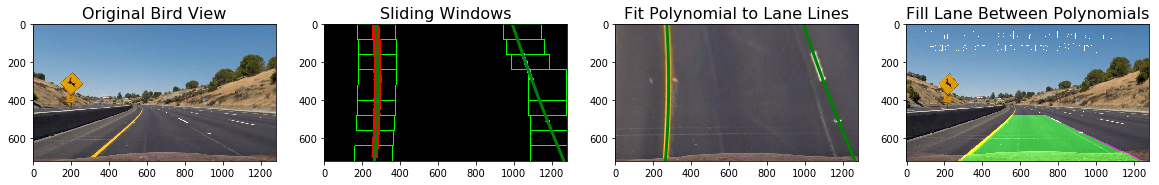

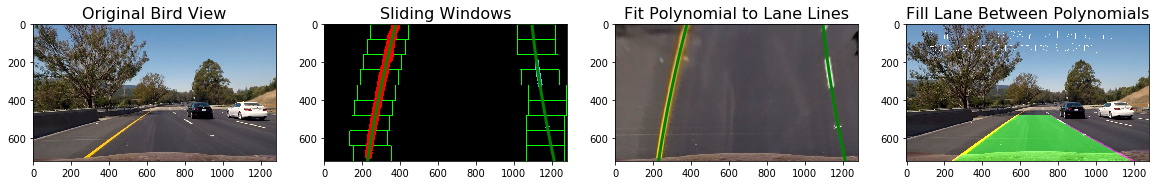

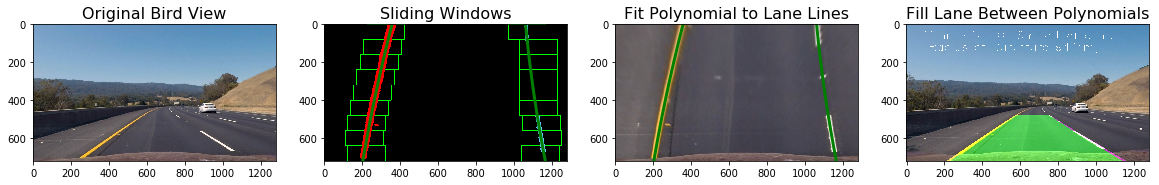

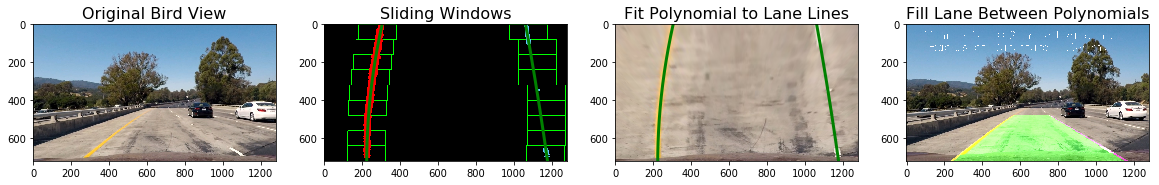

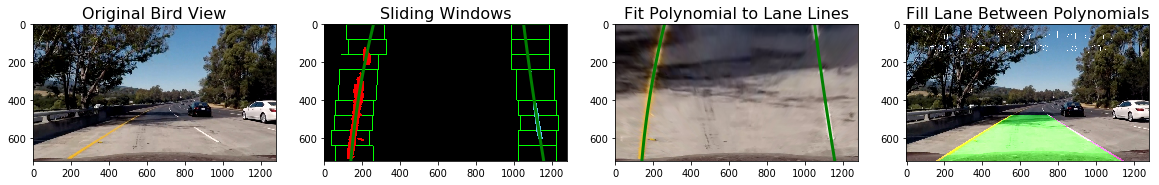

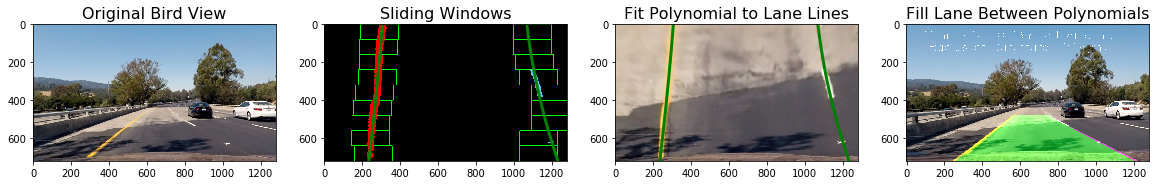

In [46]:
for fimage in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(fimage)
    undistorted = undistort_image(image, mtx, dist)
    warped, M, Minv = birds_eye_transform(undistorted)
    combined_binary = threashold_image(warped)
    calculated_data, visualization_data = fill_lane(combined_binary)
    # Draw complete image
    result_temp = draw_fit_lane(image, combined_binary, calculated_data, Minv)
    result = calculate_curv_rad_and_center(result_temp, combined_binary, calculated_data )
    show_lane_fitted(undistorted, combined_binary, result, calculated_data, visualization_data, Minv)
    

### Define a class to receive the characteristics of each line detection

### Create Video pipeline

In [ ]:
def process_video(image):
    #convert the image from BGR to RGB in order to process it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
    undistorted = undistort_image(image, mtx, dist)
    warped, M, Minv = birds_eye_transform(undistorted)
    combined_binary = threashold_image(warped)
    calculated_data, _ = fill_lane(combined_binary)
    if calculated_data[0] is not None and calculated_data[1] is not None:
        # Draw complete image
        result_temp = draw_fit_lane(undistorted, combined_binary, calculated_data, Minv)
        result = calculate_curv_rad_and_center(result_temp, combined_binary, calculated_data )
    else:
        result = image
    return result

In [ ]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,24)
processed_video = video_input1.fl_image(process_video)
%time processed_video.write_videofile(video_output1, audio=False)

video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')#.subclip(22,24)
processed_video = video_input1.fl_image(process_video)
%time processed_video.write_videofile(video_output1, audio=False)

clip = VideoFileClip("project_video_output.mp4").subclip(8,10).resize(0.3)
clip.write_gif("project_video_output.gif")

clip = VideoFileClip("challenge_video_output.mp4").subclip(8,10).resize(0.3)
clip.write_gif("challenge_video_output.gif")

#### 